In [1]:
import Main
from Analyser import *

In [2]:
modelName = 'Ruler2'

In [3]:
# Some PyABC magic to get our set of parameters
from pyabc import (ABCSMC, Distribution, RV, MultivariateNormalTransition)
import scipy as sp
import scipy.stats as st
import tempfile
import os
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def model(params):
    return Main.generate_and_analyse(modelName, params)

In [5]:
def sigfigs(n):
    print('%.2f'%n,end='')

In [6]:
sigfigs(1.005)
sigfigs(1.005)

1.001.00

In [7]:
deref = {
    'rule_1_0' : 1,
    'rule_1_1' : 0,
}
deref_metrics = Main.generate_and_analyse("Ruler2",deref)

In [8]:
three_prong = {
    'rule_1_0' : 0,
    'rule_1_1' : 1,
    'general_thickness': 0.39,
    'section_1_h' : 21
}
three_prong_metrics = Main.generate_and_analyse("Ruler2",three_prong)

In [9]:
for (k,v) in deref_metrics.items():
    v2 = three_prong_metrics[k]
    if k[-3:] != 'xyz':
        diff = v - v2
        print(k.ljust(30) + '\t',end='')
        sigfigs(v)
        print('\t',end='')
        sigfigs(v2)
        print('\t',end='')
        sigfigs(diff)
        print()
    else:
        diff = (v[0]-v2[0],v[1]-v2[1],v[2]-v2[2])
        print(k.ljust(30) + '\t',end='')
        
        print('(',end='')
        for i in range(3):
            sigfigs(v[i])
            print(',',end='')
        print(')',end='')
        
        print('\t',end='')
        
        print('(',end='')
        for i in range(3):
            sigfigs(v2[i])
            print(',',end='')
        print(')',end='')
        
        print('\t',end='')
        
        print('(',end='')
        for i in range(3):
            sigfigs(diff[i])
            print(',',end='')
        print(')',end='')   
        
        print()

parentAngle_mean              	40.00	20.00	20.00
parentAngle_variance          	4.00	2.00	2.00
length_mean                   	3.98	7.44	-3.47
length_variance               	1.17	2.09	-0.92
verticalOrientation_mean      	71.92	37.14	34.78
verticalOrientation_variance  	33.61	18.06	15.56
horizontalOrientation_mean    	162.71	184.49	-21.78
horizontalOrientation_variance	101.68	105.39	-3.72
q1_xyz                        	(37.96,25.72,48.86,)	(0.78,21.76,0.78,)	(37.18,3.96,48.08,)
q2_xyz                        	(75.84,25.31,108.11,)	(25.59,13.09,27.21,)	(50.25,12.22,80.91,)
q3_xyz                        	(88.04,28.07,97.90,)	(68.33,26.73,69.99,)	(19.71,1.34,27.91,)
xyz                           	(88.04,78.40,108.11,)	(68.33,76.89,69.99,)	(19.71,1.52,38.13,)
trunk_length                  	10.00	21.00	-11.00
totalBiomass                  	791.45	798.65	-7.20


In [10]:
# We have two models that are similar in every regard other than their branching structure
# We want to try and infer the rule probabilities
# We first normalise the height and biomass produced by changing the thickness and growth height of the two models, since without doing this the optimizer would just pick the rule that produced biomass as opposed to picking the rule that best fit structure

In [11]:
metrics = {
    'general_thickness': (0.35, 0.55),
    'section_1_h' : (5, 30),
    'rule_1_0': (0,1),
    'rule_1_1': (0,1),
}

In [12]:
prior = Distribution(rule_1_0            =RV("uniform", 0, 1),
                     rule_1_1            =RV("uniform", 0, 1),
                     general_thickness   =RV("uniform", 0.35, 0.55),
                     section_1_h         =RV("uniform", 5, 30),
                    )

In [13]:
target_metrics = Main.generate_and_analyse('rules_test_1', {})

In [14]:
abc = ABCSMC(model, prior, distance)

In [15]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db"))

In [16]:
abc.new(db_path, target_metrics)

INFO:History:Start <ABCSMC(id=6, start_time=2019-05-20 16:43:19.508874, end_time=None)>
INFO:Epsilon:initial epsilon is 13.432355641506563


6

In [17]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10)

INFO:ABC:t:0 eps:13.432355641506563
INFO:ABC:t:1 eps:9.951640738091688
INFO:ABC:t:2 eps:7.410428734164387
INFO:ABC:t:3 eps:5.72706274988211
INFO:ABC:t:4 eps:4.744206546572456
INFO:ABC:t:5 eps:4.320298356201358
INFO:ABC:t:6 eps:3.656283840790083
INFO:ABC:t:7 eps:3.1375625194639847
INFO:ABC:t:8 eps:2.7801024619625636
INFO:ABC:t:9 eps:2.5315279427240345
INFO:History:Done <ABCSMC(id=6, start_time=2019-05-20 16:43:19.508874, end_time=2019-05-20 16:45:59.270152)>


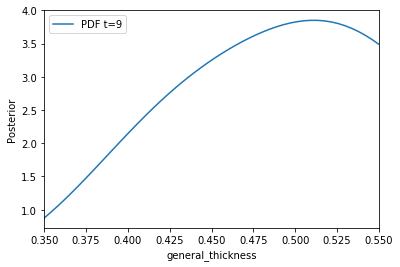

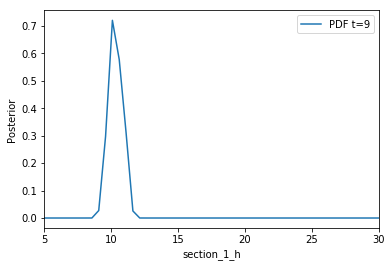

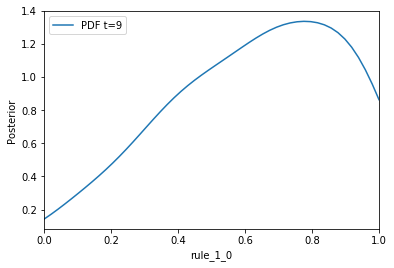

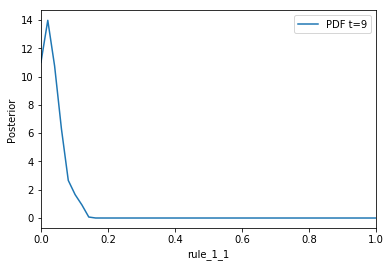

In [18]:
# Visualise results
from pyabc.visualization import plot_kde_1d
for (k,v) in metrics.items():
    fig, ax = plt.subplots()
    for t in range(history.max_t, history.max_t+1):
        df, w = history.get_distribution(m=0, t=t)
        plot_kde_1d(df, w,
                    xmin=v[0], xmax=v[1],
                    x=k, ax=ax,
                    label="PDF t={}".format(t))
    ax.legend();
    fig.savefig('another_rules_test/t1_'+k+'_kde')

In [19]:
# Fitting the other one

In [20]:
target_metrics = Main.generate_and_analyse('rules_test_2', {})

In [21]:
abc = ABCSMC(model, prior, distance)

In [22]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db"))

In [23]:
abc.new(db_path, target_metrics)

INFO:History:Start <ABCSMC(id=7, start_time=2019-05-20 16:45:59.985660, end_time=None)>
INFO:Epsilon:initial epsilon is 24.47009569857166


7

In [24]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10)

INFO:ABC:t:0 eps:24.47009569857166
INFO:ABC:t:1 eps:17.096785997038562
INFO:ABC:t:2 eps:13.264613739719968
INFO:ABC:t:3 eps:10.330646747748036
INFO:ABC:t:4 eps:8.774833023027595
INFO:ABC:t:5 eps:7.523480661568197
INFO:ABC:t:6 eps:6.581624503230421
INFO:ABC:t:7 eps:5.5655407241953325
INFO:ABC:t:8 eps:4.401492971259806
INFO:ABC:t:9 eps:3.6201102936152334
INFO:History:Done <ABCSMC(id=7, start_time=2019-05-20 16:45:59.985660, end_time=2019-05-20 16:47:43.473292)>


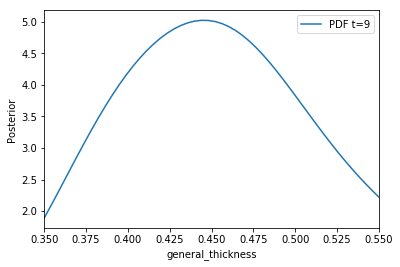

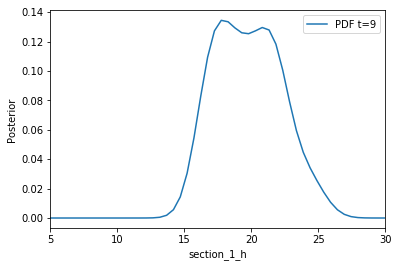

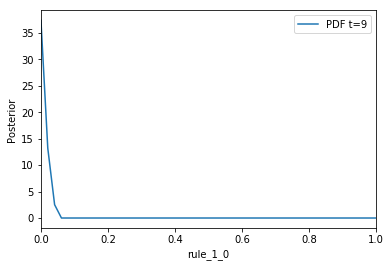

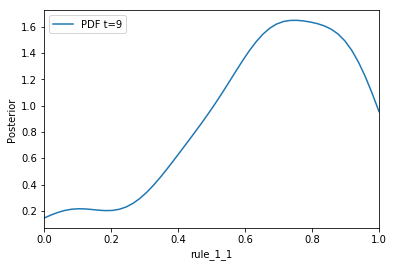

In [25]:
# Visualise results
from pyabc.visualization import plot_kde_1d
for (k,v) in metrics.items():
    fig, ax = plt.subplots()
    for t in range(history.max_t, history.max_t+1):
        df, w = history.get_distribution(m=0, t=t)
        plot_kde_1d(df, w,
                    xmin=v[0], xmax=v[1],
                    x=k, ax=ax,
                    label="PDF t={}".format(t))
    ax.legend();
    fig.savefig('another_rules_test/t2_'+k+'_kde')